# 3D Tomography Experiments

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

### medium

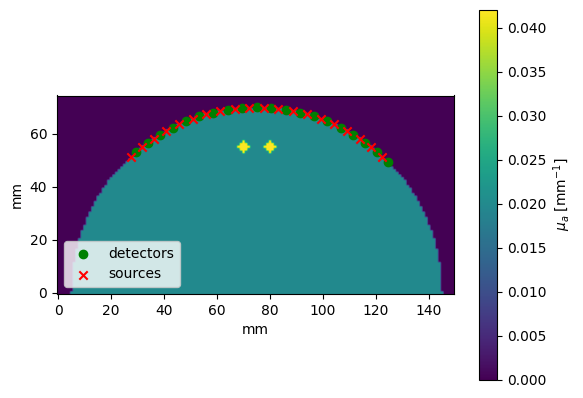

In [3]:
from problems.two_balls import two_balls_2d_sensors, two_balls_2d_medium

medium_bg, medium_true = two_balls_2d_medium(
    contrast=1.1, voxels_per_dim=150, r_ball_mm=2, depth_mm=20, ball_separation_mm=10
)

noptodes = 20
sensors = two_balls_2d_sensors(noptodes, medium_bg)

medium_true.plot_mua(sensors)

## Forward

In [4]:
from solver import Solver, jacobian

solver = Solver(medium_bg, sensors, tstart=0, tend=1e-8, tstep=5e-10)

In [5]:
nx, ny, nz = medium_bg.nx, medium_bg.ny, medium_bg.nz
ndet, nsrc = sensors.ndet, sensors.nsrc
nt = solver.nt

In [6]:
folder = "data/two_balls_2d_same_photon/2023-12-07_nphoton=1e+07_noptodes=20_nx=150_ny=75_nz=1_nt=20_tstart=0_tend=1e-08_tstep=5e-10"
data_bg = np.load(f"{folder}/data_bg.npy")
data_true = np.load(f"{folder}/data_true.npy")
J = np.load(f"{folder}/jacobian.npy")

# initialize arrays
# J = np.zeros((nz, ny, nx, nt, ndet, nsrc))
# data_bg = np.zeros((nt, ndet, nsrc))
# data_true = np.zeros((nt, ndet, nsrc))

In [7]:
start_idx = 0

# data_bg[...,7].mean()

# # # print the indices with a mean of 0
# # missing_sources = [idx for idx in range(data_bg.shape[-1]) if data_bg[...,idx].mean() == 0]
# # nsrc = data_bg.shape[-1]
# # missing_sources



In [8]:
# # remove the missing sources from the data
# data_bg = np.delete(data_bg, missing_sources, axis=-1)
# data_true = np.delete(data_true, missing_sources, axis=-1)
# J = np.delete(J, missing_sources, axis=-1)

In [9]:
from saver import Saver


t = np.linspace(solver.tstart, solver.tend, nt)

nphoton = 1e7

# save the data
params = {
    "nphoton": nphoton,
    "noptodes": noptodes,
    "nx": nx,
    "ny": ny,
    "nz": nz,
    "nt": nt,
    "tstart": solver.tstart,
    "tend": solver.tend,
    "tstep": solver.tstep,
}

saver = Saver("two_balls_2d_same_photon", params)

In [59]:

# run forward for all sources (for both the ground truth and background)
for src_idx in range(start_idx, nsrc):
    print(f"Running source {src_idx+1}/{nsrc}")

    solver.medium = medium_bg
    res_bg, cfg_bg = solver.forward(src_idx, random_seed=1, nphoton=nphoton)
    data_bg[..., src_idx] = solver.get_td_data(res_bg, medium_bg.optical_properties)
    J[..., src_idx] = jacobian(res_bg, cfg_bg)

    solver.medium = medium_true
    # res_true, cfg_true = solver.forward(src_idx, random_seed=2, nphoton=nphoton)
    data_true[..., src_idx] = solver.get_td_data(res_bg, medium_true.optical_properties)

    saver.save(data_bg, "data_bg")
    saver.save(data_true, "data_true")
    saver.save(J, "jacobian")

Running source 1/20
nphoton: 1e+07
tstart: 0
tstep: 5e-10
tend: 1e-08
maxdetphoton: 1e+07
issrcfrom0: 1
replaydet: -1
srcpos: [0, 51.4026, 122.516, 1]
srcdir: [0, -0.734322, -0.678801, 0]
issavedet: 1
issaveseed: 1


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2023 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.org/                #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse,#
#  Please consider using JSON (https://n

## Inversion

In [51]:
data_true.shape

(20, 20, 20)

In [10]:
# get the condition number of J
J_c = J.reshape((nz*ny*nx*nt, ndet*nsrc))
cond = np.linalg.cond(J_c)
print(f"Condition number of J: {cond}")

Condition number of J: 1811.3105758421084


In [19]:
# J_CW = 
J_cw = np.expand_dims(J.sum(axis=3), axis=3)
# J_cw.shape

J_c = J_cw.reshape((nz*ny*nx, ndet*nsrc))
cond = np.linalg.cond(J_c)
print(f"Condition number of J: {cond}")

Condition number of J: 4601.249179259179


In [10]:
# add noise
noise_level = 0.1 # percent of mean for each channel
noise = np.random.normal(0, noise_level**2 * np.sqrt(np.abs(data_true)), data_true.shape)
data_true_noisy = data_true + noise

In [11]:
data_bg_cw = np.expand_dims(data_bg.sum(axis=0), axis=0)
data_true_cw = np.expand_dims(data_true_noisy.sum(axis=0), axis=0)
J_cw = np.expand_dims(J.sum(axis=3), axis=3)

In [17]:
from solver import invert, compute_dphi

# normalize true data
dphi_fd = compute_dphi(data_bg, data_true_noisy)
dmua = invert(dphi_fd, J, regularization='ridge', alpha=1)

mua_bg = medium_bg.get_mua()
mua_new = mua_bg + dmua

Inversion error: 1.62e-02


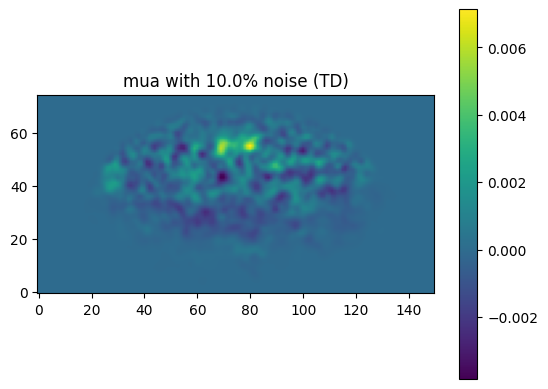

In [19]:
# blur the result
from scipy.ndimage import gaussian_filter
dmua2 = gaussian_filter(dmua, sigma=1) #+ mua_bg

plt.imshow(dmua2[nz//2,...])
plt.colorbar()
# set the min/max in the colorbar to plus/minus 0.01
# plt.clim(0, 0.04)
# plt.clim(-0.01, 0.01)
# flip y axis
plt.gca().invert_yaxis()
plt.title(f"mua with {noise_level*100}% noise (TD)")
plt.show()